In [1]:

print("hello world")


hello world


In [2]:
import datetime as dt
from collections import defaultdict

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, regularizers, optimizers
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pycaret import regression
# from pycaret.time_series import TSForecastingExperiment
# from pyhht.visualization import plot_imfs
# from pyhht.emd import EmpiricalModeDecomposition

from functions import (
    bucketize_column, plot_the_loss_curve, create_model, train_model,
    replace_with_linear_interpolation, plot_the_loss_curves, tf_error,
    evaluate_model, predict_model, np_error)

plt.rcParams.update({'figure.figsize': (7, 7)})


In [3]:

def my_decompose(values, period, model='additive'):
    'multiplicative'
    result = seasonal_decompose(
        values, model=model, extrapolate_trend='freq', period=period)

    # result.plot().suptitle(f'{model} Decompose {period}', fontsize=22)

    return result


def mean_seasonal(seasonal, period):
    seasonal = seasonal[:len(seasonal) - len(seasonal) % period]

    sections = np.split(seasonal, range(period, len(seasonal), period))
    print(np.diff(sections, axis=0).T)
    return np.mean(sections, axis=0), sections


def plot_seasonal(seasonal, period):
    fig, axs = plt.subplots(1, 2, figsize=(16, 7))
    mean, sections = mean_seasonal(seasonal, period)

    for section in sections:
        axs[0].plot(section)

    axs[1].plot(seasonal)
    plt.show()


def apply(period, values):
    decomposed = my_decompose(values, period)
    decomposed.plot().suptitle(f'additive Decompose {period}', fontsize=22)
    plt.show()

    plot_seasonal(np.array(decomposed.trend), (period))
    plot_seasonal(np.array(decomposed.seasonal), (period))
    plot_seasonal(np.array(decomposed.resid), (period))

    values = values - decomposed.trend
    values = values - decomposed.seasonal

    return values, decomposed


In [4]:
train = pd.read_csv("train.csv")
train


,datetime,total
0,01.01.2005 00:00:00,?
1,01.01.2005 01:00:00,154140
2,01.01.2005 02:00:00,157818
3,01.01.2005 03:00:00,149311
4,01.01.2005 04:00:00,138282
...,...,...
35059,31.12.2008 19:00:00,249376
35060,31.12.2008 20:00:00,246511
35061,31.12.2008 21:00:00,226469
35062,31.12.2008 22:00:00,199907


In [5]:
holidays = pd.read_csv("holidays.csv")
holidays


,Unnamed: 0,Date
0,0,2005-01-03
1,1,2005-01-04
2,2,2005-01-05
3,3,2005-01-06
4,4,2005-01-07
5,5,2005-01-10
6,6,2005-02-23
7,7,2005-03-07
8,8,2005-05-02
9,9,2005-05-09


In [6]:
train['total'].replace("?", -1000, inplace=True)
train['total'] = train['total'].astype(np.int32)

train[train['total'] <= 0]


,datetime,total
0,01.01.2005 00:00:00,-1000
3936,14.06.2005 00:00:00,-1000
3944,14.06.2005 08:00:00,-1000
3970,15.06.2005 10:00:00,-1000
3973,15.06.2005 13:00:00,-1000
5279,08.08.2005 23:00:00,-1000
5289,09.08.2005 09:00:00,-1000
10778,26.03.2006 02:00:00,-1000
11736,05.05.2006 00:00:00,-1000
11744,05.05.2006 08:00:00,-1000


In [7]:
time_format = "%d.%m.%Y %H:%M:%S"
train["datetime"] = [dt.datetime.strptime(
    s, time_format) for s in train["datetime"]]
train.sort_values(by=["datetime"], inplace=True)


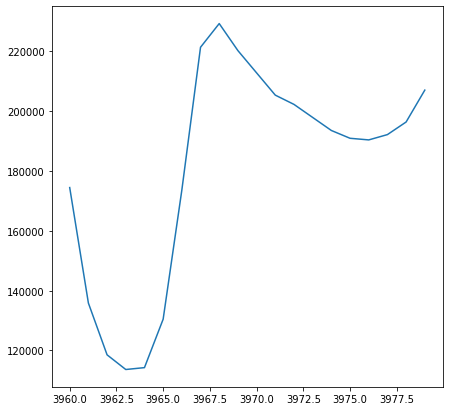

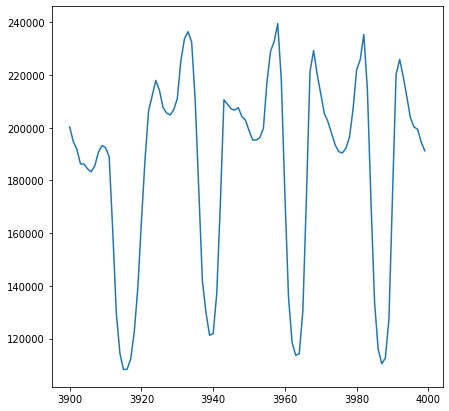

In [8]:
# replace non-positive values with linear interpolation
replace_with_linear_interpolation(train, train['total'] <= 0)

plt.plot(train[3960:3980]["total"])
plt.show()
plt.plot(train[3900:4000]["total"])
plt.show()


In [9]:
original_total = np.array(train["total"].copy())


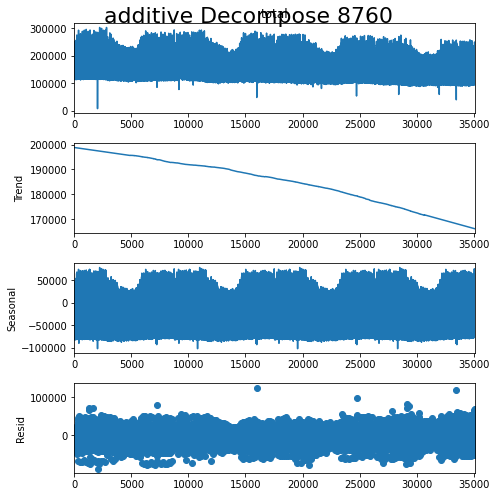

[[ -6135.89864109  -6215.57631279  -9422.0841895 ]
 [ -6136.54943325  -6215.51894977  -9422.66609589]
 [ -6136.84194916  -6215.78824201  -9423.41940639]
 ...
 [ -6219.72488584  -9417.8946347  -10886.22738463]
 [ -6217.02585616  -9420.43615868 -10885.88214746]
 [ -6215.91141553  -9421.68772831 -10885.34261806]]


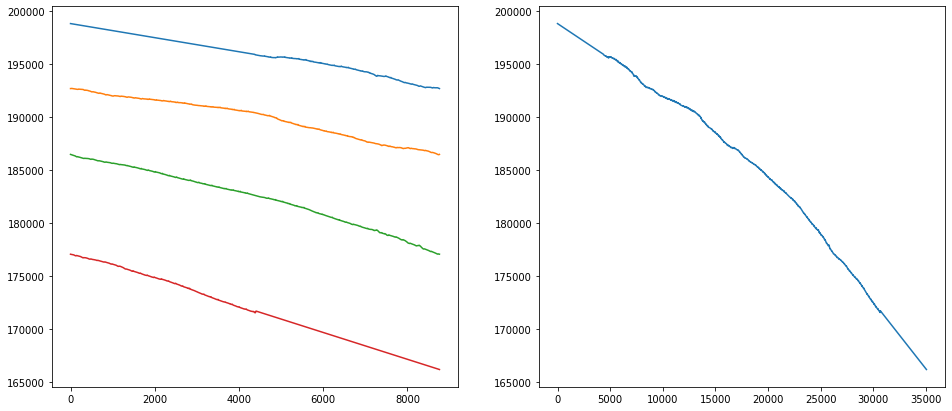

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


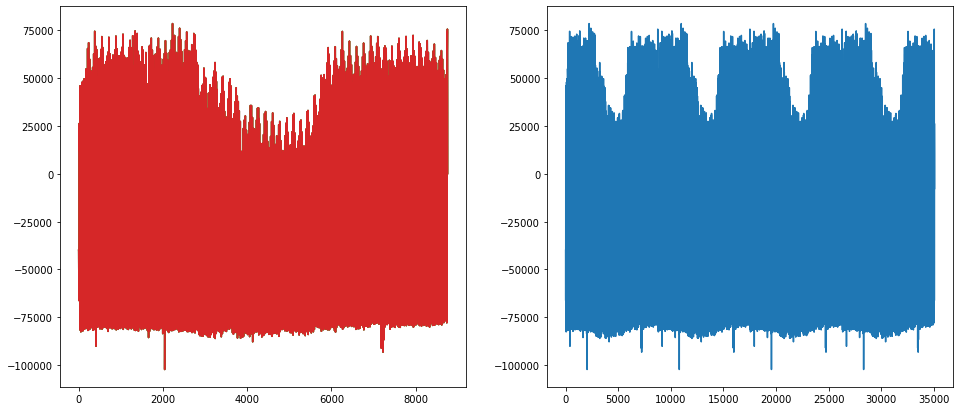

[[ -9031.10135891   7348.57631279  -1507.9158105 ]
 [  2646.54943325  -1928.48105023   4463.66609589]
 [ -1308.15805084    422.78824201   2923.41940639]
 ...
 [ -6061.27511416   -810.1053653  -12403.77261537]
 [   521.02585616  -4201.56384132  20584.88214746]
 [  4981.91141553  -6768.31227169  56158.34261806]]


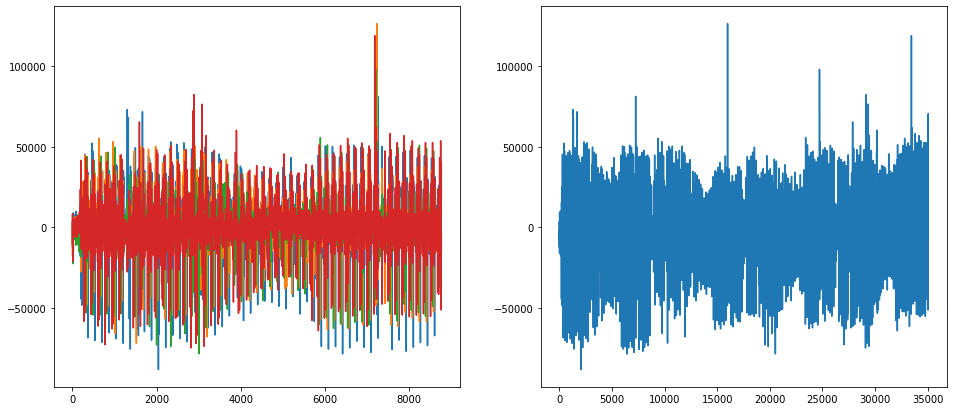

In [10]:
_, year_decomposed = apply(24*365, train["total"])


In [11]:
global_trend = year_decomposed.trend
train['total'] -= global_trend


In [12]:
# global_trend_shift = np.mean(global_trend)
# global_trend -= global_trend_shift


In [13]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c


def func(x, a, b, c, e, f):
    return a * np.exp(-b * x) + c + e * (x + f)**2


# def func(x, a, b, c, d, e):
#     return a + b*x + c*x**2 + d*x**3 + e*x**4  # a*np.exp(-b*x) +


# def func(x, a, b, c, e, f, g, h):
#     return a * np.exp(-b * x) + c + e * f**2 + g * h**3


# def func(x, a, b, offset):
#     return 1.0 / (1.0 + np.exp(-a * (x-b))) + offset

# method : {'lm', 'trf', 'dogbox'}
popt, pcov = curve_fit(func, global_trend.index,
                       global_trend)  # , method='dogbox')
print(popt)
# [ 6.80965581e+02  5.54983660e+05  2.01353392e+05 -1.40515861e-05 1.50944272e+04]


[ 6.80965581e+02  5.54983660e+05  2.01353392e+05 -1.40515861e-05
  1.50944272e+04]


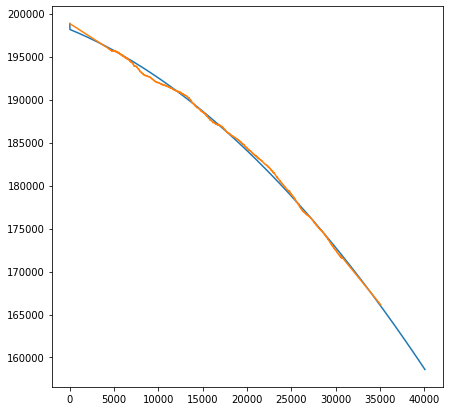

In [14]:
_x_data = np.arange(len(global_trend) + 5000)
plt.plot(_x_data, func(_x_data, *popt),
         label=f'fit: {popt}')  # a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(global_trend, label="data")
plt.show()


In [15]:
# replace outlier values with linear interpolation
print(len(train[train['total'] < -100_000]) / len(train))

replace_with_linear_interpolation(train, train['total'] < -100_000)


0.0002851927903262606


In [16]:
train['total'].describe()


count     35064.000000
mean        182.310707
std       44510.593192
min      -98843.734361
25%      -27666.754693
50%       11630.643215
75%       32287.640240
max      105232.374088
Name: total, dtype: float64

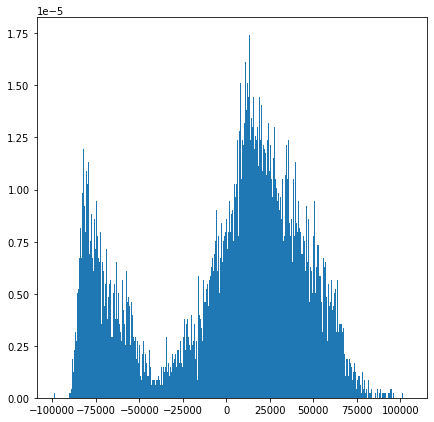

In [17]:
plt.hist(train["total"], 1500, density=True)
plt.show()


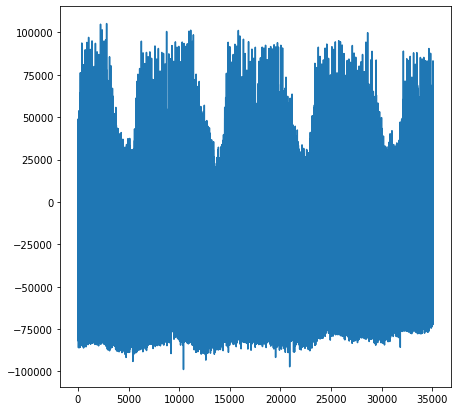

In [18]:
plt.plot(train["total"])
plt.show()


In [19]:
# plt.psd(train["total"], 5000, 1/0.01)
# plt.show()


In [20]:
# plt.plot(np.fft.fftshift(np.fft.fft(train["total"])))
# plt.show()
# plt.plot(np.fft.fft(train["total"]))
# plt.show()


In [21]:
# acfarray = np.array(list(enumerate(acf(train["total"], nlags=1024))))
# most_periods = acfarray[acfarray[:, 1].argsort()[::-1]][:, 0][1:].astype(int)

def get_the_best_period(values, nlags=1024):
    acfarray = np.array(list(enumerate(acf(values, nlags=nlags))))
    most_periods = acfarray[acfarray[:, 1].argsort()[::-1]][:, 0].astype(int)
    for period in most_periods:
        if period not in (0, 1):
            return period


In [23]:
train = train.set_index(pd.DatetimeIndex(train['datetime']))


In [25]:
train['total']

datetime
2005-01-01 00:00:00   -48370.820159
2005-01-01 01:00:00   -44692.155426
2005-01-01 02:00:00   -41013.490693
2005-01-01 03:00:00   -49519.825961
2005-01-01 04:00:00   -60548.161228
                           ...     
2008-12-31 19:00:00    83225.760820
2008-12-31 20:00:00    80362.027598
2008-12-31 21:00:00    60321.294375
2008-12-31 22:00:00    33760.561153
2008-12-31 23:00:00   -15059.172069
Name: total, Length: 35064, dtype: float64

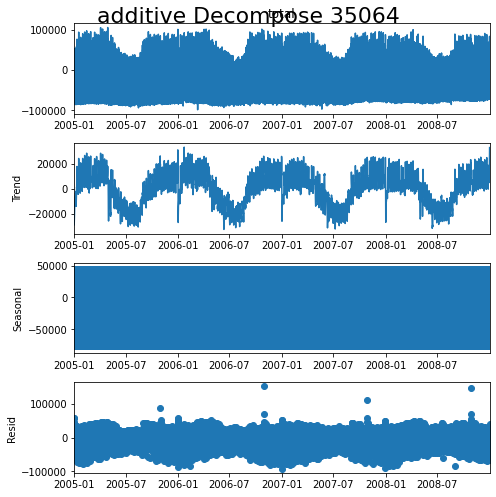

[]


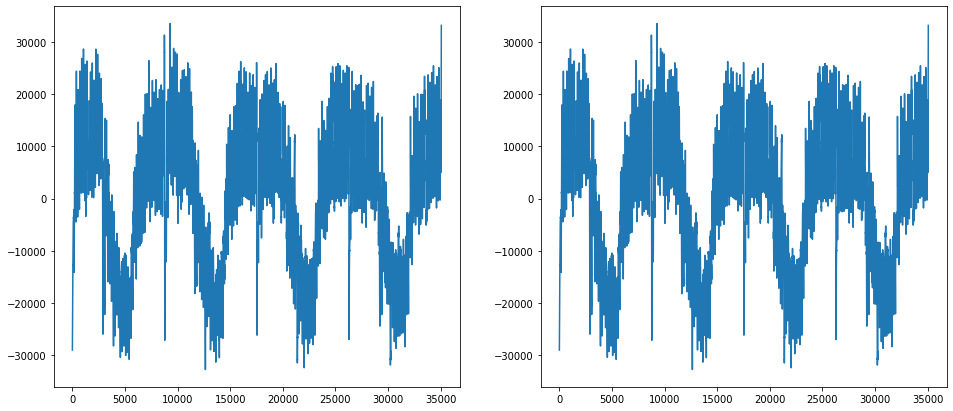

[]


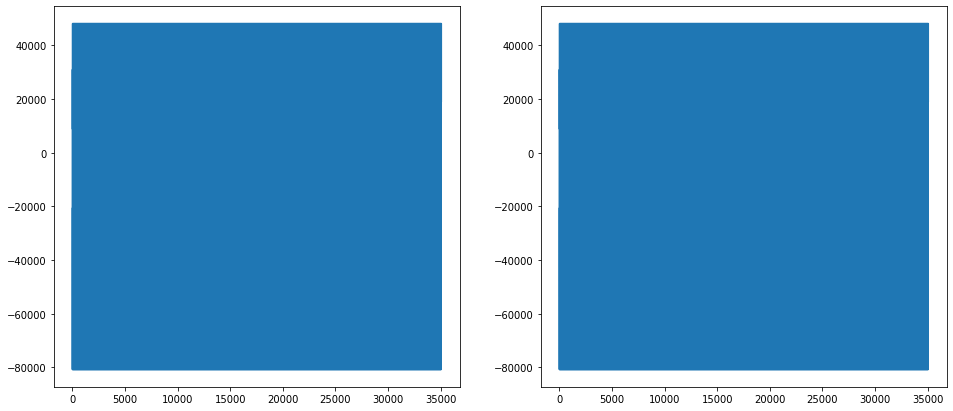

[]


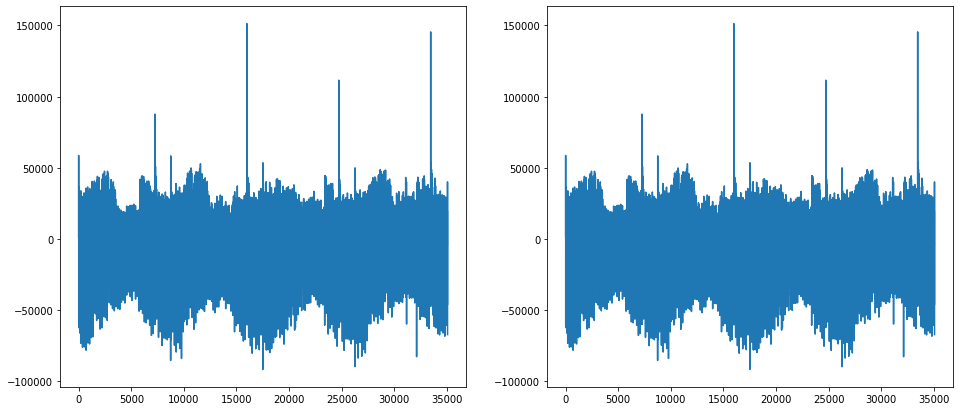

In [26]:
period = len(train)
decomposed = seasonal_decompose(train['total'], model='additive', extrapolate_trend='freq')
decomposed.plot().suptitle(f'additive Decompose {period}', fontsize=22)
plt.show()

plot_seasonal(np.array(decomposed.trend), (period))
plot_seasonal(np.array(decomposed.seasonal), (period))
plot_seasonal(np.array(decomposed.resid), (period))


In [ ]:

period = len(train)
decomposed2 = seasonal_decompose(decomposed.seasonal, model='additive', extrapolate_trend='freq')
decomposed2.plot().suptitle(f'additive Decompose {period}', fontsize=22)
plt.show()

plot_seasonal(np.array(decomposed2.trend), (period))
plot_seasonal(np.array(decomposed2.seasonal), (period))
plot_seasonal(np.array(decomposed2.resid), (period))


In [27]:
acfarray = np.array(list(enumerate(acf(train["total"], nlags=len(train)-1))))
most_periods = acfarray[acfarray[:, 1].argsort()[::-1]][:, 0][1:].astype(int)

# periods = list(map(str, list(most_periods)))[:200]
# periods = ["24*365", "12", "24", "24*7*4", "24*365//4", "24*365//2"]
old_seasonals = dict()#defaultdict(list)

treshold = 0.00001
prev_err = np_error(global_trend, train["total"] + global_trend)
values = np.zeros(len(train))

trended = np.array(train["total"])# + global_trend)
trended_values = trended.copy()
# for i, period in enumerate(periods):
# for period in most_periods:
for period in range(1, 1500):
    # print(i, period, end=", ")
    decomposed = my_decompose(trended_values, (period))

    possible_values = values + decomposed.seasonal + global_trend
    cur_err = np_error(trended, possible_values)
    # delta = (prev_err - cur_err) / period
    print(period, prev_err - cur_err, end="\r")
    if prev_err - cur_err >= treshold:
        # print("yay")
        print(period, prev_err, cur_err, prev_err - cur_err)
        # plt.plot(train["total"] + global_trend)
        # plt.plot(possible_values)
        # plt.show()
        # plt.plot(decomposed.seasonal[:period])
        # plt.show()
        prev_err = cur_err
        values += decomposed.seasonal
        trended_values -= decomposed.seasonal
        old_seasonals[period] = decomposed.seasonal

        # plt.plot(values)
        # plt.show()

values = trended_values

# deltas = [(0, 0) for _ in range(len(train)//2+1)]
# for period in range(1, 1000):
#     decomposed = my_decompose(train["total"], (period))

#     cur_err = np_error(trended, decomposed.seasonal)
#     print(period, prev_err - cur_err, end="\r")
#     deltas[period] = (max((prev_err - cur_err) / period, 0), decomposed.seasonal)

#     # print(prev_err - sum(deltas))

# # print(sorted(zip(enumerate(deltas)), key=lambda x: x[1]))

# for period, (v, seasonal) in enumerate(deltas):
#     if v > 0:
#         train["total"] -= seasonal
#         old_seasonals[period] = seasonal



KeyboardInterrupt: 

In [ ]:

seasonals = dict()
for period, seasonal in old_seasonals.items():
    # period = eval(period)
    # seasonals[period] = mean_seasonal(np.sum(seasonal, axis=0), period)[0]
    seasonals[period] = mean_seasonal(seasonal, period)[0]

In [ ]:
# for period, seasonal in sorted(seasonals.items()):
#     print(period)
#     plt.plot(seasonal)
#     plt.show()


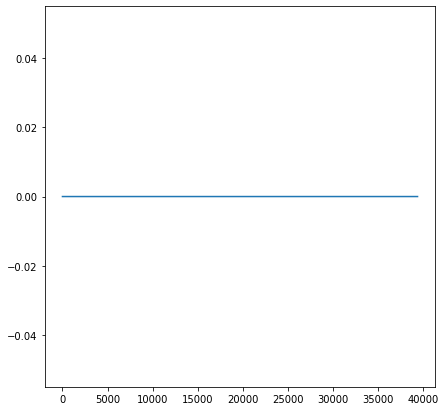

In [ ]:
to_predict = 4344
neened_len = len(train) + to_predict

extended = np.zeros(neened_len)
for period, seasonal in seasonals.items():
    extended += np.tile(seasonal,
                        int(np.ceil(neened_len/len(seasonal))))[:neened_len]

plt.plot(extended)
plt.show()


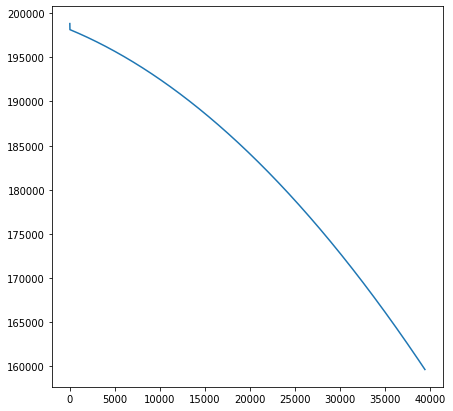

In [ ]:
extended += func(np.arange(neened_len), *popt)
# extended += global_trend_shift

plt.plot(extended)
plt.show()


In [ ]:
# 01.01.2009 00:00:00 по 30.06.2009 23:00:00

last = train["datetime"][len(train)-1]
for _ in range(to_predict):
    last += dt.timedelta(hours=1)
    train.loc[train.shape[0]] = [last] + [pd.NA]*(len(train.columns)-1)
train[-to_predict+1:]


,datetime,total
35065,2009-01-01 01:00:00,<NA>
35066,2009-01-01 02:00:00,<NA>
35067,2009-01-01 03:00:00,<NA>
35068,2009-01-01 04:00:00,<NA>
35069,2009-01-01 05:00:00,<NA>
...,...,...
39403,2009-06-30 19:00:00,<NA>
39404,2009-06-30 20:00:00,<NA>
39405,2009-06-30 21:00:00,<NA>
39406,2009-06-30 22:00:00,<NA>


In [ ]:
train["year"] = [date.year for date in train["datetime"]]
train["season"] = [date.month % 4 for date in train["datetime"]]
train["month"] = [date.month for date in train["datetime"]]
train["week_of_year"] = [date.isocalendar().week for date in train["datetime"]]
# train["week_of_month"] = [(date.day + date.replace(day=1).weekday() - 1)//7 for date in train["datetime"]]
train["is_weekend"] = [int(date.weekday() >= 5) for date in train["datetime"]]
train["weekday"] = [date.weekday() for date in train["datetime"]]
train["hour"] = [date.hour for date in train["datetime"]]

train[['data', 'time']] = train["datetime"].astype(
    str).str.split(' ', expand=True)
train["data"] = pd.to_datetime(train["data"], format="%Y-%m-%d")
train['isHoliday'] = train['data'].dt.date.astype(
    'datetime64').isin(holidays['Date'])
train['isHoliday'] = train['isHoliday'].astype(np.float64)
del train['data']
del train['time']


In [ ]:
set([date.year for date in train["datetime"]])


{2005, 2006, 2007, 2008, 2009}

In [ ]:
train["year"] -= 2005
train["year"] /= 4  # so 2009 would work

train["season"] /= 3

train["month"] -= 1
train["month"] /= 11

train["week_of_year"] -= 1
train["week_of_year"] /= 51

# train["week_of_month"] /= 4

train["weekday"] /= 6

train["hour"] /= 23


In [ ]:
ind = len(train)-to_predict
X_submit = pd.DataFrame(train[ind:].values, columns=train.columns)
train.drop(train[ind:].index, inplace=True)
del X_submit["total"]
del X_submit["datetime"]
for column in X_submit.columns:
    X_submit[column] = X_submit[column].astype(np.float64)
X_submit


,year,season,month,week_of_year,is_weekend,weekday,hour,isHoliday
0,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.000000,1.0
1,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.043478,1.0
2,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.086957,1.0
3,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.130435,1.0
4,1.0,0.333333,0.000000,0.000000,0.0,0.500000,0.173913,1.0
...,...,...,...,...,...,...,...,...
4339,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.826087,0.0
4340,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.869565,0.0
4341,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.913043,0.0
4342,1.0,0.666667,0.454545,0.509804,0.0,0.166667,0.956522,0.0


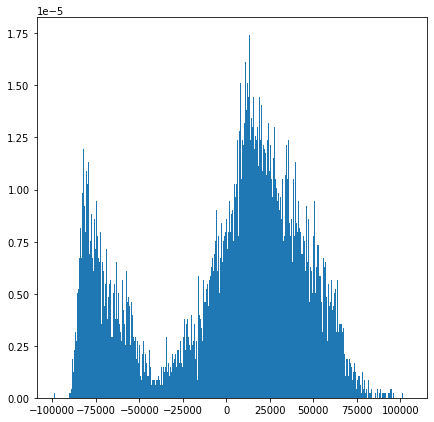

In [ ]:
plt.hist(values, 1500, density=True)
plt.show()


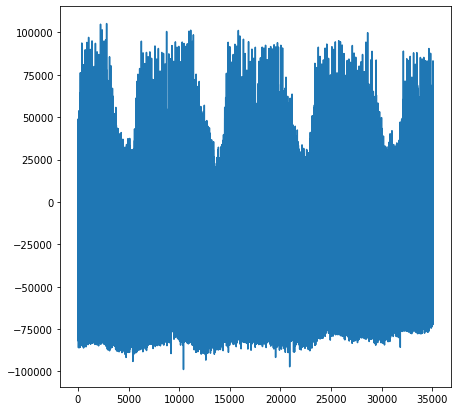

In [ ]:
plt.plot(values[:])
plt.show()


[[ 0.00000000e+00 -2.97236473e+04]
 [ 1.00000000e+00 -2.93158751e+04]
 [ 2.00000000e+00 -2.89096740e+04]
 ...
 [ 3.50610000e+04  3.54283434e+04]
 [ 3.50620000e+04  3.57895009e+04]
 [ 3.50630000e+04  3.61534808e+04]]


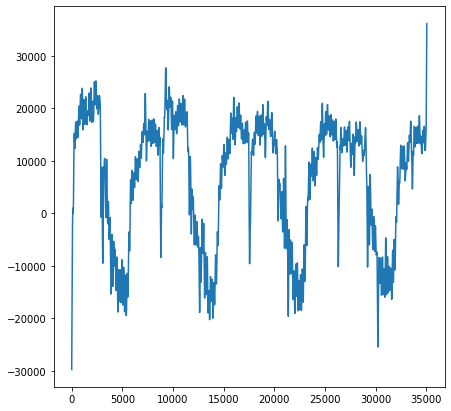

In [ ]:
frac = 0.004
print(lowess(values, np.arange(len(values)), frac=frac))
train["leftovers"] = values

noise = train["leftovers"]

train["smoothed_leftovers"] = lowess(
    values, np.arange(len(values)), frac=frac)[:, 1]
plt.plot(train["smoothed_leftovers"])
plt.show()


In [ ]:
train.sort_values(by=["season", "month", "is_weekend",
                      "weekday", "hour", "week_of_year", "year"])


,datetime,total,year,season,month,week_of_year,is_weekend,weekday,hour,isHoliday,leftovers,smoothed_leftovers
2232,2005-04-04 00:00:00,-15613.136216,0.00,0.0,0.272727,0.254902,0,0.0,0.0,0.0,-15613.136216,24807.886263
10968,2006-04-03 00:00:00,-15329.073002,0.25,0.0,0.272727,0.254902,0,0.0,0.0,0.0,-15329.073002,22275.730250
19704,2007-04-02 00:00:00,-7727.884703,0.50,0.0,0.272727,0.254902,0,0.0,0.0,0.0,-7727.884703,17886.446144
2400,2005-04-11 00:00:00,-18594.46108,0.00,0.0,0.272727,0.274510,0,0.0,0.0,0.0,-18594.461080,24968.284360
11136,2006-04-10 00:00:00,-18399.623687,0.25,0.0,0.272727,0.274510,0,0.0,0.0,0.0,-18399.623687,21690.232354
...,...,...,...,...,...,...,...,...,...,...,...,...
7943,2005-11-27 23:00:00,26181.43379,0.00,1.0,0.909091,0.901961,1,1.0,1.0,0.0,26181.433790,17774.506685
16679,2006-11-26 23:00:00,37200.285788,0.25,1.0,0.909091,0.901961,1,1.0,1.0,0.0,37200.285788,18697.415526
25415,2007-11-25 23:00:00,33026.075514,0.50,1.0,0.909091,0.901961,1,1.0,1.0,0.0,33026.075514,18469.375910
34151,2008-11-23 23:00:00,33009.526695,0.75,1.0,0.909091,0.901961,1,1.0,1.0,0.0,33009.526695,16553.910353


In [ ]:
train.describe()


,year,season,month,week_of_year,is_weekend,weekday,hour,isHoliday,leftovers,smoothed_leftovers
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,0.375257,0.498745,0.502085,0.499685,0.286105,0.499886,0.500000,0.035592,182.310707,6786.650108
std,0.279589,0.373802,0.313523,0.295280,0.451946,0.333538,0.300969,0.185273,44510.593192,11941.056234
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-98843.734361,-29723.647344
25%,0.250000,0.000000,0.272727,0.235294,0.000000,0.166667,0.250000,0.000000,-27666.754693,-3388.652730
50%,0.500000,0.333333,0.545455,0.490196,0.000000,0.500000,0.500000,0.000000,11630.643215,11585.026290
75%,0.750000,1.000000,0.818182,0.764706,1.000000,0.833333,0.750000,0.000000,32287.640240,16070.365437
max,0.750000,1.000000,1.000000,1.019608,1.000000,1.000000,1.000000,1.000000,105232.374088,36153.480788


In [ ]:
train.corr()


,year,season,month,week_of_year,is_weekend,weekday,hour,isHoliday,leftovers,smoothed_leftovers
year,1.000000e+00,4.124187e-04,-1.204013e-03,-5.821027e-03,-3.289666e-03,-3.210946e-03,4.849968e-16,6.430556e-03,-0.001089,-0.068553
season,4.124187e-04,1.000000e+00,-6.780733e-02,-5.912926e-02,-1.926463e-03,1.676365e-03,-2.014111e-16,6.449144e-04,-0.007532,-0.011389
month,-1.204013e-03,-6.780733e-02,1.000000e+00,9.701007e-01,4.134813e-03,5.804036e-03,-8.924218e-17,-1.512510e-01,-0.005141,-0.063757
week_of_year,-5.821027e-03,-5.912926e-02,9.701007e-01,1.000000e+00,6.006435e-03,6.484008e-03,-9.069401e-17,-1.599932e-01,-0.008784,-0.077857
is_weekend,-3.289666e-03,-1.926463e-03,4.134813e-03,6.006435e-03,1.000000e+00,7.910701e-01,-8.554814e-18,-6.439470e-02,-0.017234,-0.042134
weekday,-3.210946e-03,1.676365e-03,5.804036e-03,6.484008e-03,7.910701e-01,1.000000e+00,-1.147355e-18,-7.747008e-02,-0.020366,-0.068305
hour,4.849968e-16,-2.014111e-16,-8.924218e-17,-9.069401e-17,-8.554814e-18,-1.147355e-18,1.000000e+00,-2.448812e-19,0.689789,0.003477
isHoliday,6.430556e-03,6.449144e-04,-1.512510e-01,-1.599932e-01,-6.439470e-02,-7.747008e-02,-2.448812e-19,1.000000e+00,-0.027235,-0.101417
leftovers,-1.089026e-03,-7.532143e-03,-5.140984e-03,-8.783932e-03,-1.723379e-02,-2.036569e-02,6.897887e-01,-2.723459e-02,1.000000,0.229575
smoothed_leftovers,-6.855276e-02,-1.138901e-02,-6.375663e-02,-7.785668e-02,-4.213357e-02,-6.830458e-02,3.476526e-03,-1.014171e-01,0.229575,1.000000


In [ ]:
# plt.plot(train["season"])
# plt.plot(train["month"])
# plt.plot(train["is_weekend"][:24*7*2])
# plt.plot(train["weekday"][:24*7*2])
# plt.plot(train["hour"][:24*3])


In [ ]:
selected = list(train.columns)
selected.remove("datetime")
selected.remove("total")
selected.remove("leftovers")
selected.remove("smoothed_leftovers")
label_name = "leftovers"

on_full_data = False


In [ ]:
# learning_rate = 0.0002
# # regularization_rate = 0.01
# epochs = 300
# batch_size = 30
# validation_split = 0.15

if on_full_data:
    X_train, y_train = train[selected], train[label_name]
else:
    X_train, _, y_train, _ = train_test_split(
        train[selected], train[label_name], test_size=0.1)

# eda = TSForecastingExperiment()
# fig_kwargs={'renderer': 'notebook'}
# eda.setup(data=y, fh=to_predict, fig_kwargs=fig_kwargs, use_gpu=Truw)

# s = regression.setup(
#     data=train[selected + [label_name]], test_data=y_train, target=label_name,
#     fold_strategy='timeseries',
#     numeric_features=["year", "season", "month", "week_of_year", "weekday", "hour"],
#     categorical_features=["isHoliday", "is_weekend"],
#     fold=3, transform_target=True, session_id=123, data_split_shuffle=False,
#     pca=True, use_gpu=True
# )

# best = regression.compare_models(sort='MAE')
# print(best)

# prediction_holdout = regression.redict_model(best)
# print(prediction_holdout)

# # , kernel_regularizer=regularizers.L1(regularization_rate))
# # feature_cross_feature_layer = layers.DenseFeatures(feature_columns)
# # my_model = create_model(learning_rate, feature_cross_feature_layer)
# # epochs, rmse, history = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)

# # # ['loss', 'tf_error', 'val_loss', 'val_tf_error']
# # plot_the_loss_curves(epochs, history["tf_error"],
# #                     history["val_tf_error"])


In [ ]:
if on_full_data:
    # X = pd.concat([train[selected], X_submit])
    X = X_submit
    extended = extended[-to_predict:]
else:
    X = train[selected][len(X_train):]
    extended = extended[len(X_train):len(train)]

# predictions = regression.predict_model(best, data=X)
# final_best = regression.finalize_model(best)
# print(final_best)

# prediction = regression.predict_model(final_best, data=X)
# predictions_future.head()

# prediction = predict_model(my_model, X, batch_size).T[0]
# plt.plot(prediction)
# plt.show()


0.11110465867238652
original


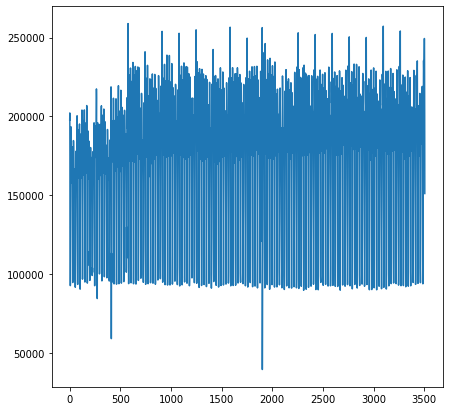

predicted


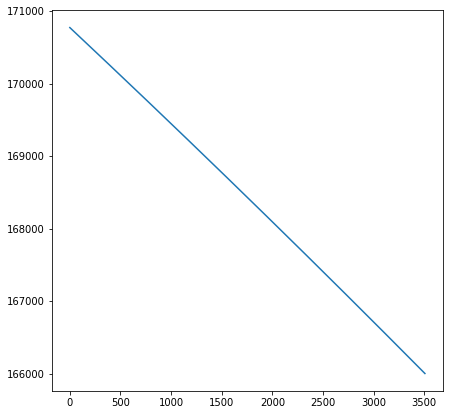

diff


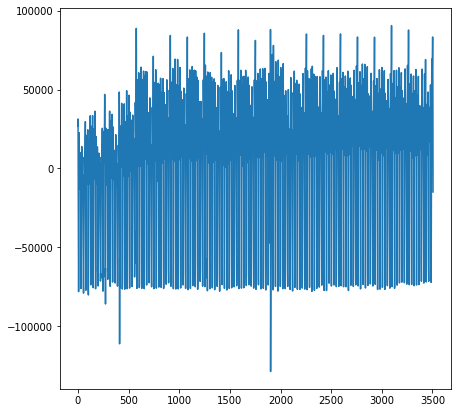

In [ ]:
end_prediction = extended  # + prediction
if not on_full_data:
    a = original_total[len(X_train):]
    b = end_prediction
    print(np_error(a, b))
    print("original")
    plt.plot(a)
    plt.show()
    print("predicted")
    plt.plot(b)
    plt.show()
    print("diff")
    plt.plot(a - b)
    plt.show()


In [ ]:
# learning_rate = 0.0002
# # regularization_rate = 0.01
# epochs = 300
# batch_size = 30
# validation_split = 0.15

if on_full_data:
    X_train, y_train = train[selected], train[label_name]
else:
    X_train, _, y_train, _ = train_test_split(
        train[selected], train[label_name], test_size=0.1)

# eda = TSForecastingExperiment()
# fig_kwargs={'renderer': 'notebook'}
# eda.setup(data=y, fh=to_predict, fig_kwargs=fig_kwargs, use_gpu=Truw)

# s = regression.setup(
#     data=train[selected + [label_name]], test_data=y_train, target=label_name,
#     fold_strategy='timeseries',
#     numeric_features=["year", "season", "month", "week_of_year", "weekday", "hour"],
#     categorical_features=["isHoliday", "is_weekend"],
#     fold=3, transform_target=True, session_id=123, data_split_shuffle=False,
#     pca=True, use_gpu=True
# )

# best = regression.compare_models(sort='MAE')
# print(best)

# prediction_holdout = regression.redict_model(best)
# print(prediction_holdout)

# # , kernel_regularizer=regularizers.L1(regularization_rate))
# # feature_cross_feature_layer = layers.DenseFeatures(feature_columns)
# # my_model = create_model(learning_rate, feature_cross_feature_layer)
# # epochs, rmse, history = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)

# # # ['loss', 'tf_error', 'val_loss', 'val_tf_error']
# # plot_the_loss_curves(epochs, history["tf_error"],
# #                     history["val_tf_error"])


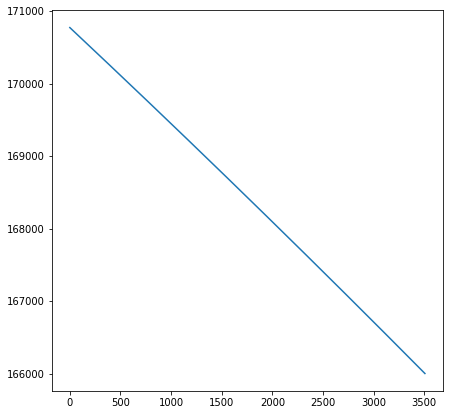

In [ ]:
plt.plot(end_prediction)
plt.show()


In [ ]:
if on_full_data:
    with open("answer2.txt", "w") as f:
        for v in end_prediction:
            f.write(str(v))
            f.write('\n')
